<a href="https://colab.research.google.com/github/Koanah/CNNs_rediscovered-/blob/main/02_Resnet_unet_luna16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LUNA16 — Resnet50 U-Net


 - HU windowing → [0,1]
 - Center jitter (±5 mm) on positives
 - Robust negatives (structured + random fallback)
 - GroupKFold(5), EarlyStopping(min_delta=1e-3, patience=4)
 - ModelCheckpoint per fold, CSVLogger
 - Loss/Dice/IoU curves, best-fold selection
- Patch-based inference (Gaussian blending) for full slice


In [219]:
!pip -q install SimpleITK scipy scikit-learn matplotlib pandas

import os, sys, math, random, gc, warnings, glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import GroupKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger

SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
os.system("nvidia-smi -L")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0


0

In [235]:
from google.colab import drive
drive.mount('/content/drive')

CFG = {
    "base_path": "/content/drive/MyDrive/LUNA16_trial",
    "annotations_csv": "/content/drive/MyDrive/LUNA16_trial/annotations.csv",
    "patch_size": 224,
    "box_scale": 1.6,
    "center_jitter_mm": 5.0,
    "neg_per_pos": 1,
    "batch": 8,
    "epochs": 25,
    "folds": 5,
    "base_lr": 1e-4,
    "patience": 5,
    "results_dir": "./results",
    "model_dir": "./models",
    "logs_dir": "./logs"
}
os.makedirs(CFG["results_dir"], exist_ok=True)
os.makedirs(CFG["model_dir"], exist_ok=True)
os.makedirs(CFG["logs_dir"], exist_ok=True)

assert os.path.exists(CFG["annotations_csv"]), "annotations.csv not found"
ann = pd.read_csv(CFG["annotations_csv"])
cols_needed = {"seriesuid","coordX","coordY","coordZ","diameter_mm"}
assert cols_needed.issubset(ann.columns), f"annotations.csv must have {cols_needed}"
print("Annotations:", ann.shape, list(ann.columns))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Annotations: (1186, 5) ['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm']


In [ ]:
def load_luna_scans(base_path):
    scans, skipped = {}, []
    for i in range(10):
        subset_path = os.path.join(base_path, f"subset{i}")
        if not os.path.exists(subset_path):
            continue
        for file in os.listdir(subset_path):
            if file.endswith(".mhd"):
                mhd_path = os.path.join(subset_path, file)
                raw_path = mhd_path.replace(".mhd", ".raw")
                if not os.path.exists(raw_path):
                    skipped.append(file); continue
                try:
                    scan = sitk.ReadImage(mhd_path)
                    scans[file.replace(".mhd","")] = scan
                except:
                    skipped.append(file)
    print(f" Loaded {len(scans)} scans successfully")
    print(f" Skipped {len(skipped)} scans (missing/corrupt)")
    return scans

print("Loading scans…")
SCANS = load_luna_scans(CFG["base_path"])

In [222]:
print (len(SCANS),"loaded successfully")

708 loaded successfully


In [223]:

def hu_to_float01(arr, hu_min=-1000, hu_max=400):
    arr = np.clip(arr, hu_min, hu_max).astype(np.float32)
    return (arr - hu_min) / float(hu_max - hu_min + 1e-6)

def world_to_index(img, xyz):
    return np.array(img.TransformPhysicalPointToIndex(tuple(map(float, xyz))), dtype=np.int64)

def crop_patch_and_mask_from_ann(scan, coordX, coordY, coordZ, diameter_mm,
                                 patch_size=224, box_scale=1.6, pad=4):
    arr = sitk.GetArrayFromImage(scan)  # [Z,Y,X]
    Z, H, W = arr.shape
    spacing = np.array(scan.GetSpacing(), dtype=np.float32)  # (sx, sy, sz)

    ijk = world_to_index(scan, [coordX, coordY, coordZ])  # (x,y,z)
    x_idx, y_idx, z_idx = int(ijk[0]), int(ijk[1]), int(ijk[2])
    if z_idx < 0 or z_idx >= Z:
        return None, None, None

    img2d = hu_to_float01(arr[z_idx])
    rx = (diameter_mm/2.0) / (spacing[0] + 1e-6)
    ry = (diameter_mm/2.0) / (spacing[1] + 1e-6)

    box_w = int(max(8, math.ceil(box_scale * 2*rx)))
    box_h = int(max(8, math.ceil(box_scale * 2*ry)))
    x1 = max(0, x_idx - box_w//2 - pad); x2 = min(W, x_idx + box_w//2 + pad)
    y1 = max(0, y_idx - box_h//2 - pad); y2 = min(H, y_idx + box_h//2 + pad)
    if x2 <= x1 or y2 <= y1:
        return None, None, None

    crop = img2d[y1:y2, x1:x2]
    if crop.size == 0:
        return None, None, None

    mask = np.zeros_like(crop, dtype=np.uint8)
    cx = x_idx - x1; cy = y_idx - y1
    axes = (max(1,int(round(rx))), max(1,int(round(ry))))
    try:
        cv2.ellipse(mask, (int(cx), int(cy)), axes, 0, 0, 360, 1, thickness=-1)
    except:
        mask[max(0,cy-axes[1]):min(mask.shape[0], cy+axes[1]),
             max(0,cx-axes[0]):min(mask.shape[1], cx+axes[0])] = 1

    patch = cv2.resize(crop, (patch_size, patch_size), interpolation=cv2.INTER_LINEAR)
    msk   = cv2.resize(mask, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)

    patch = patch[..., np.newaxis].astype(np.float32)
    msk   = msk[..., np.newaxis].astype(np.float32)
    return patch, msk, z_idx

def sample_negative_patch(scan, avoid_coords, patch_size=224, box_px=64, tries=30):
    """
    Structured negatives first; if none found, fallback to random 'hard' negative.
    """
    arr = sitk.GetArrayFromImage(scan)
    Z, H, W = arr.shape

    # Structured negatives
    for _ in range(tries):
        z = np.random.randint(0, Z)
        img2d = hu_to_float01(arr[z])
        x = np.random.randint(box_px//2, W - box_px//2)
        y = np.random.randint(box_px//2, H - box_px//2)
        ok = True
        for (zx, zy, zz, rx, ry) in avoid_coords:
            if zz != z: continue
            if abs(x - zx) <= 2*rx and abs(y - zy) <= 2*ry:
                ok = False; break
        if not ok: continue
        x1 = x - box_px//2; x2 = x + box_px//2
        y1 = y - box_px//2; y2 = y + box_px//2
        crop = img2d[y1:y2, x1:x2]
        if crop.shape[0] != box_px or crop.shape[1] != box_px: continue
        patch = cv2.resize(crop, (patch_size, patch_size), interpolation=cv2.INTER_LINEAR)
        patch = patch[..., np.newaxis].astype(np.float32)
        mask  = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
        return patch, mask

    # Fallback random hard negative
    z = np.random.randint(0, Z)
    img2d = hu_to_float01(arr[z])
    y = np.random.randint(64, H - 64)
    x = np.random.randint(64, W - 64)
    crop = img2d[y-32:y+32, x-32:x+32]
    crop = cv2.resize(crop, (patch_size, patch_size))
    patch = crop[..., np.newaxis].astype(np.float32)
    mask = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
    return patch, mask




In [ ]:
BASE_PATH = "/content/drive/MyDrive/LUNA16_trial"

In [226]:
# Build dataset
PATCH_SIZE = CFG["patch_size"]
NEG_PER_POS = CFG["neg_per_pos"]
BOX_SCALE = CFG["box_scale"]
JITTER = CFG["center_jitter_mm"]

X_list, Y_list, G_list, size_mm_list = [], [], [], []

print("Building (patch, mask) pairs from annotations…")
series_groups = ann["seriesuid"].unique().tolist()
for uid, df_grp in tqdm(ann.groupby("seriesuid"), total=len(series_groups)):
    scan = SCANS.get(uid, None)
    if scan is None:
        continue

    pos_records, avoid = [], []
    arr = sitk.GetArrayFromImage(scan)
    for _, r in df_grp.iterrows():
        # Jitter in world mm
        jx = r.coordX + np.random.uniform(-JITTER, JITTER)
        jy = r.coordY + np.random.uniform(-JITTER, JITTER)
        jz = r.coordZ

        p, m, z = crop_patch_and_mask_from_ann(
            scan, jx, jy, jz, r.diameter_mm,
            patch_size=PATCH_SIZE, box_scale=BOX_SCALE
        )
        if p is None:
            continue
        X_list.append(p); Y_list.append(m); G_list.append(uid); size_mm_list.append(float(r.diameter_mm))
        pos_records.append((p,m))

        # Neg-avoid list (in voxel px)
        ijk = world_to_index(scan, [r.coordX,r.coordY,r.coordZ])
        sx, sy, _ = scan.GetSpacing()
        rx = (r.diameter_mm/2.0) / (sx + 1e-6)
        ry = (r.diameter_mm/2.0) / (sy + 1e-6)
        avoid.append((int(ijk[0]), int(ijk[1]), int(ijk[2]), int(rx), int(ry)))

    # sample negatives
    n_negs = len(pos_records) * NEG_PER_POS
    got = 0
    while got < n_negs:
        pn, mn = sample_negative_patch(scan, avoid, patch_size=PATCH_SIZE, box_px=64)
        if pn is None: break
        X_list.append(pn); Y_list.append(mn); G_list.append(uid); size_mm_list.append(0.0)
        got += 1

X = np.asarray(X_list, dtype=np.float32)
Y = np.asarray(Y_list, dtype=np.float32)
G = np.asarray(G_list)
sizes_mm = np.asarray(size_mm_list, dtype=np.float32)

print("Dataset:", X.shape, Y.shape, " | patients:", len(np.unique(G)))
print("Positive pixel fraction:", float(Y.mean()))


Building (patch, mask) pairs from annotations…


100%|██████████| 601/601 [01:57<00:00,  5.10it/s]


Dataset: (1896, 224, 224, 1) (1896, 224, 224, 1)  | patients: 475
Positive pixel fraction: 0.08056645840406418


In [ ]:
# Preview: 3 images before/after preprocessing
def preview_preprocessing(n=3):
    n = min(n, len(X))
    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    for i in range(n):
        raw = (X[i,...,0] * 255).astype(np.uint8)
        hu = X[i,...,0]
        norm = X[i,...,0]
        axes[i,0].imshow(raw, cmap="gray");  axes[i,0].set_title("Original-ish"); axes[i,0].axis("off")
        axes[i,1].imshow(hu, cmap="gray");   axes[i,1].set_title("HU Windowed"); axes[i,1].axis("off")
        axes[i,2].imshow(norm, cmap="gray"); axes[i,2].set_title("Normalized & Resized"); axes[i,2].axis("off")
    plt.tight_layout(); plt.show()

preview_preprocessing(3)

In [227]:
# tf.data pipeline
BATCH = CFG["batch"]

def aug_pair(img, msk):
    if tf.random.uniform([]) < 0.5:
        img = tf.image.flip_left_right(img); msk = tf.image.flip_left_right(msk)
    if tf.random.uniform([]) < 0.5:
        img = tf.image.flip_up_down(img);    msk = tf.image.flip_up_down(msk)
    img = tf.clip_by_value(img + tf.random.normal(tf.shape(img), stddev=0.02), 0., 1.)
    return img, msk

def make_ds(X, Y, training=True, batch=BATCH):
    ds = tf.data.Dataset.from_tensor_slices((X,Y))
    if training:
        ds = ds.shuffle(min(len(X), 4096), seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(aug_pair, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

    return ds

In [229]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred)
    denom = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.*inter + smooth) / (denom + smooth)

def dice_loss(y_true, y_pred): return 1.0 - dice_coef(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice_loss(y_true, y_pred)


In [230]:
def patch_based_inference(model, img2d, patch_size=224, stride=112, blend_sigma=12):
    H, W = img2d.shape
    gk = cv2.getGaussianKernel(patch_size, blend_sigma)
    blend = (gk @ gk.T); blend /= blend.max()
    prob_map = np.zeros((H, W), np.float32)
    weight   = np.zeros((H, W), np.float32)

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = img2d[y:y+patch_size, x:x+patch_size]
            pin = patch[np.newaxis, ..., np.newaxis]
            pred = model.predict(pin, verbose=0)[0, ..., 0]
            prob_map[y:y+patch_size, x:x+patch_size] += pred * blend
            weight[y:y+patch_size, x:x+patch_size]   += blend

    return prob_map / np.maximum(weight, 1e-6)

def visualize_patch_inference(model, scan, z_index, thr=0.5):
    slice_img = sitk.GetArrayFromImage(scan)[z_index]
    img2d = hu_to_float01(slice_img)
    pred = patch_based_inference(model, img2d, patch_size=CFG["patch_size"], stride=112, blend_sigma=12)

    base = cv2.cvtColor((img2d*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    mask = np.zeros_like(base); mask[...,0] = (pred>thr).astype(np.uint8)*255
    overlay = cv2.addWeighted(base, 1.0, mask, 0.5, 0)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(img2d, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(pred, cmap='inferno'); plt.title("Probability"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay (thr={thr})"); plt.axis('off')
    plt.show()


# Model: ResNet50 U-Net

In [232]:
from tensorflow.keras.applications import ResNet50

def conv_blk(x, f):
    x = layers.Conv2D(f, 3, padding="same", use_bias=False, kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def dec_blk(x, skip, f):
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip])
    x = conv_blk(x, f); x = conv_blk(x, f)
    return x

def build_unet_resnet50(input_shape=(224,224,1)):
    inp = layers.Input(input_shape)
    x3  = layers.Concatenate()([inp, inp, inp])  # 1->3 channels
    enc = ResNet50(weights="imagenet", include_top=False, input_tensor=x3)
    s1 = enc.get_layer("conv1_relu").output
    s2 = enc.get_layer("conv2_block3_out").output
    s3 = enc.get_layer("conv3_block4_out").output
    s4 = enc.get_layer("conv4_block6_out").output
    b  = enc.get_layer("conv5_block3_out").output

    d1 = dec_blk(b,  s4, 256)
    d2 = dec_blk(d1, s3, 128)
    d3 = dec_blk(d2, s2, 64)
    d4 = dec_blk(d3, s1, 32)
    d4 = layers.UpSampling2D()(d4)
    out = layers.Conv2D(1,1,activation="sigmoid")(d4)
    return Model(inp, out, name="ResNet50_UNet")


In [236]:
gkf = GroupKFold(n_splits=CFG["folds"])
fold_scores, histories = [], []

for fold,(tr,va) in enumerate(gkf.split(X, Y, groups=G),1):
    print(f"\n=== ResNet50-U-Net Fold {fold}/{CFG['folds']} ===")
    Xt,Yt,Xv,Yv = X[tr],Y[tr],X[va],Y[va]
    ds_tr, ds_va = make_ds(Xt,Yt,training=True), make_ds(Xv,Yv,training=False)

    model = build_unet_resnet50((CFG['patch_size'], CFG['patch_size'], 1))
    model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss=bce_dice_loss,
                  metrics=[dice_coef, iou_metric])
    run_name=f"resnet_fold{fold}"
    cbs=[
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=CFG['patience'], restore_best_weights=True, verbose=1),
        ModelCheckpoint(os.path.join(CFG['model_dir'], f"{run_name}.keras"), save_best_only=True, monitor="val_loss", verbose=1),
        CSVLogger(os.path.join(CFG['logs_dir'], f"{run_name}.csv"))
    ]
    hist = model.fit(ds_tr, validation_data=ds_va, epochs=CFG['epochs'], verbose=1, callbacks=cbs)
    histories.append(hist)

    # Eval on validation
    preds = []
    B = CFG["batch"]
    for i in range(0, len(Xv), B):
        preds.append(model.predict(Xv[i:i+B], verbose=0))
    P = np.concatenate(preds, axis=0)
    y_true = Yv.reshape(-1)
    y_pred = P.reshape(-1)
    yb = (y_pred > 0.5).astype(np.uint8)
    yt = y_true.astype(np.uint8)
    inter = (yb*yt).sum()
    dice = (2*inter + 1e-6) / (yb.sum() + yt.sum() + 1e-6)
    union = yb.sum() + yt.sum() - inter
    iou  = (inter + 1e-6) / (union + 1e-6)
    fold_scores.append({"fold":fold, "Dice":dice, "IoU":iou})
    np.save(os.path.join(CFG["results_dir"], f"resnet_fold{fold}_metrics.npy"), np.array([dice, iou]))



=== ResNet50-U-Net Fold 1/5 ===
Epoch 1/25
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - dice_coef: 0.2399 - iou_metric: 0.3432 - loss: 0.8643
Epoch 1: val_loss improved from inf to 0.78126, saving model to ./models/resnet_fold1.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 108s 235ms/step - dice_coef: 0.2402 - iou_metric: 0.3442 - loss: 0.8635 - val_dice_coef: 0.1606 - val_iou_metric: 0.2186 - val_loss: 0.7813 - learning_rate: 1.0000e-04
Epoch 2/25
189/190 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - dice_coef: 0.3828 - iou_metric: 0.6889 - loss: 0.5621
Epoch 2: val_loss improved from 0.78126 to 0.74670, saving model to ./models/resnet_fold1.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - dice_coef: 0.3828 - iou_metric: 0.6890 - loss: 0.5619 - val_dice_coef: 0.1224 - val_iou_metric: 3.9212e-11 - val_loss: 0.7467 - learning_rate: 1.0000e-04
Epoch 3/25
189/190 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - dice_coef: 0.4029 - iou_metric: 0.6987 - loss: 0.5146
Epoch 3: val_loss improved from 0.74670 to 0.70321, savi

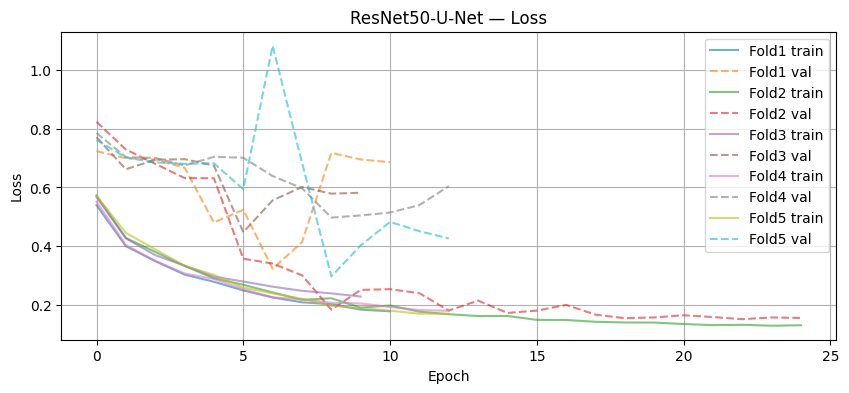


Fold summary:
   fold      Dice       IoU
0     1  0.727272  0.571427
1     2  0.869261  0.768754
2     3  0.588259  0.416690
3     4  0.465264  0.303156
4     5  0.723431  0.566699

Best fold is Fold 2 (Dice=0.8693)
Model path: ./models/resnet_fold2.keras


In [234]:
plt.figure(figsize=(10,4))
for i,h in enumerate(histories,1):
    plt.plot(h.history["loss"], label=f"Fold{i} train", alpha=0.6)
    plt.plot(h.history["val_loss"], label=f"Fold{i} val", alpha=0.6, linestyle="--")
plt.title("ResNet50-U-Net — Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

scores_df = pd.DataFrame(fold_scores)
print("\nFold summary:"); print(scores_df)
scores_df.to_csv(os.path.join(CFG["results_dir"], "resnet_fold_summary.csv"), index=False)

best_row = scores_df.loc[scores_df["Dice"].idxmax()]
best_fold = int(best_row["fold"])
print(f"\nBest fold is Fold {best_fold} (Dice={best_row['Dice']:.4f})")
print("Model path:", os.path.join(CFG["model_dir"], f"resnet_fold{best_fold}.keras"))

In [ ]:
'''#loading the model
best_model_path = "/content/models/vanilla_fold1.keras"
best_model = tf.keras.models.load_model(best_model_path,
                                        custom_objects={"dice_coef": dice_coef,
                                                     "iou_metric": iou_metric,
                                                        "bce_dice_loss": bce_dice_loss})
print(best_model.summary())

In [ ]:
# Paper visualizations
# Boxplots
plt.figure(figsize=(8,4))
scores_df.boxplot(column="Dice")
plt.title("Dice across folds — Vanilla U-Net"); plt.ylabel("Dice"); plt.grid(True); plt.show()

plt.figure(figsize=(8,4))
scores_df.boxplot(column="IoU")
plt.title("IoU across folds — Vanilla U-Net"); plt.ylabel("IoU"); plt.grid(True); plt.show()

# Mean ± Std bar
means = scores_df[["Dice","IoU"]].mean()
stds  = scores_df[["Dice","IoU"]].std()
plt.figure(figsize=(6,4))
plt.bar(["Dice","IoU"], means.values, yerr=stds.values, capsize=6)
plt.title("Mean ± Std — Vanilla U-Net"); plt.ylabel("Score"); plt.ylim(0,1); plt.grid(True, axis="y"); plt.show()

# Triplets & Error maps
def predict_batch(model, Xb, n=3):
    P = model.predict(Xb[:n], verbose=0)
    return Xb[:n], Y[:n], P

try:
    imgs, gts, prds = predict_batch(model, X, n=3)
    n = imgs.shape[0]
    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    for i in range(n):
        axes[i,0].imshow(imgs[i,...,0], cmap="gray"); axes[i,0].set_title("Image"); axes[i,0].axis("off")
        axes[i,1].imshow(gts[i,...,0], cmap="gray");  axes[i,1].set_title("GT"); axes[i,1].axis("off")
        axes[i,2].imshow((prds[i,...,0]>0.5).astype(np.float32), cmap="gray"); axes[i,2].set_title("Pred"); axes[i,2].axis("off")
    plt.tight_layout(); plt.show()

    # Error maps
    def show_error_maps(imgs, gts, prds, n=3):
        n = min(n, imgs.shape[0])
        fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
        for i in range(n):
            pred = (prds[i,...,0] > 0.5).astype(np.uint8)
            gt   = gts[i,...,0].astype(np.uint8)
            fp = np.clip(pred - gt, 0, 1)
            fn = np.clip(gt - pred, 0, 1)
            err = np.zeros((*pred.shape, 3), dtype=np.float32)
            err[...,0] = fp   # red
            err[...,2] = fn   # blue
            axes[i,0].imshow(imgs[i,...,0], cmap="gray"); axes[i,0].set_title("Image"); axes[i,0].axis("off")
            axes[i,1].imshow(gt, cmap="gray");           axes[i,1].set_title("GT"); axes[i,1].axis("off")
            axes[i,2].imshow(err);                       axes[i,2].set_title("Error Map (FP:red, FN:blue)"); axes[i,2].axis("off")
        plt.tight_layout(); plt.show()

    show_error_maps(imgs, gts, prds, n=3)
except Exception as e:
    print("Triplets/Error maps will display after training:", e)

# Small vs Large nodule performance (approx image-level)
try:
    df_sizes = pd.DataFrame({"size": sizes_mm})
    df_sizes["bin"] = pd.cut(df_sizes["size"], bins=[-1, 0.1, 6, 10, 20, 1e6], labels=["neg","≤6","6-10","10-20",">20"])

    def dice_img(y_true, y_pred, thr=0.5):
        yb = (y_pred>thr).astype(np.uint8); yt = y_true.astype(np.uint8)
        inter = (yb*yt).sum(); return (2*inter + 1e-6) / (yb.sum() + yt.sum() + 1e-6)

    dices = []
    for b in ["neg","≤6","6-10","10-20",">20"]:
        idx = np.where(df_sizes["bin"].values == b)[0]
        if len(idx) == 0:
            dices.append(np.nan); continue
        dvals = [dice_img(Y[i], model.predict(X[i:i+1], verbose=0)[0]) for i in idx]
        dices.append(np.nanmean(dvals))
    plt.figure(figsize=(7,4))
    plt.bar(["neg","≤6","6-10","10-20",">20"], dices)
    plt.ylim(0,1); plt.title("Dice by Nodule Size Bin"); plt.ylabel("Dice"); plt.grid(True, axis="y"); plt.show()
except Exception as e:
    print("Size bin analysis will run after training:", e)

# PR Curve (pixel-wise across folds)
try:
    y_prob = np.concatenate(all_val_probs)
    y_true = np.concatenate(all_val_truth).astype(np.uint8)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision)
    plt.title(f"PR Curve (pixel-wise), AP={ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True); plt.show()
except Exception as e:
    print("PRC will render after training:", e)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

def predict_full_slice(model, scan, z_index, patch_size=224, stride=112, hu_window=(-1000, 400)):
    """
    Performs sliding-window inference on a full CT slice.

    Args:
        model: trained U-Net model.
        scan: SimpleITK image from your scans dict.
        z_index: integer slice index (0 ≤ z_index < num_slices).
        patch_size: size of each window (should match training size).
        stride: step between patches (50% overlap recommended).
        hu_window: tuple defining HU clipping range.

    Returns:
        reconstructed_mask: 2D numpy array (H×W) of predicted probabilities.
    """
    # Convert scan to numpy and HU normalize
    np_img = sitk.GetArrayFromImage(scan)[z_index]
    np_img = np.clip(np_img, *hu_window).astype(np.float32)
    np_img = (np_img - hu_window[0]) / (hu_window[1] - hu_window[0] + 1e-6)
    H, W = np_img.shape

    # Prepare containers for reconstruction
    prob_map = np.zeros((H, W), np.float32)
    count_map = np.zeros((H, W), np.float32)

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = np_img[y:y+patch_size, x:x+patch_size]
            patch = patch[..., np.newaxis][None, ...]  # (1, H, W, 1)
            pred = model.predict(patch, verbose=0)[0, ..., 0]
            prob_map[y:y+patch_size, x:x+patch_size] += pred
            count_map[y:y+patch_size, x:x+patch_size] += 1

    # Normalize overlapping areas
    reconstructed_mask = prob_map / np.maximum(count_map, 1e-6)
    return reconstructed_mask


In [ ]:
def visualize_full_slice_prediction(model, scan, z_index):
    pred_mask = predict_full_slice(model, scan, z_index)
    slice_img = sitk.GetArrayFromImage(scan)[z_index]
    slice_img_norm = hu_to_float01(slice_img)
    thr = np.percentile(pred_mask, 90)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(slice_img_norm, cmap='gray')
    plt.title(f"Original Slice {z_index}")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(pred_mask, cmap='inferno')
    plt.title("Predicted Probability Map")
    plt.axis('off')

    plt.subplot(1,3,3)
    overlay = cv2.addWeighted(
        (slice_img_norm*255).astype(np.uint8), 1,
        (pred_mask > thr).astype(np.uint8)*255, 0.4, 0
    )
    plt.imshow(overlay, cmap='gray')
    plt.title("Overlay (Pred > 0.5)")
    plt.axis('off')
    plt.show()


In [ ]:
# Example usage
scan_id = list(SCANS.keys())[4]   # pick any loaded scan
slice_index = 80                  # choose slice with visible nodule
model = tf.keras.models.load_model("/content/models/resnet_fold1.keras",
                                   custom_objects={"dice_coef": dice_coef, "iou_metric": iou_metric, "bce_dice_loss": bce_dice_loss})
visualize_full_slice_prediction(model, SCANS[scan_id], z_index=slice_index)

z = 80
img = sitk.GetArrayFromImage(SCANS[scan_id])[z]
img_pre = hu_to_float01(img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Raw HU Slice")
plt.axis('off')



In [ ]:
import pandas as pd
ann = pd.read_csv("/content/drive/MyDrive/LUNA16_trial/annotations.csv")
ann.head()




In [ ]:
# Example usage
# Get the annotation row to use
annotation_row_index = 2 # Using the third annotation for visualization
annotation = ann.iloc[annotation_row_index]

scan_id = annotation.seriesuid
coordX, coordY, coordZ = annotation[["coordX", "coordY", "coordZ"]]

scan = SCANS.get(scan_id, None)

if scan is not None:
    # Convert the world coordinate Z to an index
    z_index = int(world_to_index(scan, [coordX, coordY, coordZ])[2])

    # Ensure the z_index is within the valid range for the scan
    if 0 <= z_index < sitk.GetArrayFromImage(scan).shape[0]:
        visualize_full_slice_prediction(model, scan, z_index)
    else:
        print(f"Calculated z_index ({z_index}) is out of bounds for scan {scan_id} (0 to {sitk.GetArrayFromImage(scan).shape[0]-1}). Please choose a different annotation or slice.")
else:
    print(f"Scan with seriesuid {scan_id} not found in loaded scans.")

### Predict on a PNG image

In [ ]:
# Load the PNG image
png_path = "/content/sample_data/slice-2.png" # Replace with the path to your PNG file

try:
    png_img = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)

    if png_img is None:
        raise FileNotFoundError(f"Image not found at {png_path}")

    print(f"Original PNG image shape: {png_img.shape}")

    # Preprocess the image
    # Resize to match the model input size if necessary
    if png_img.shape[0] != CFG["patch_size"] or png_img.shape[1] != CFG["patch_size"]:
        preprocessed_img = cv2.resize(png_img, (CFG["patch_size"], CFG["patch_size"]), interpolation=cv2.INTER_LINEAR)
        print(f"Resized image to {CFG['patch_size']}x{CFG['patch_size']}")
    else:
        preprocessed_img = png_img
        print("Image is already the correct size.")


    # Normalize the image (assuming the PNG is a standard 0-255 grayscale image)
    preprocessed_img = preprocessed_img.astype(np.float32) / 255.0

    # Add channel dimension (model expects input shape HxWx1)
    preprocessed_img = preprocessed_img[np.newaxis, ..., np.newaxis] # Shape becomes (1, H, W, 1)

    print("PNG image loaded and preprocessed. Shape:", preprocessed_img.shape)

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred during image loading or preprocessing: {e}")

In [ ]:
# Use the model to predict the mask
if 'preprocessed_img' in locals() and preprocessed_img is not None:
    try:
        # Ensure the model is loaded
        if 'model' not in locals() or model is None:
             model = tf.keras.models.load_model("/content/models/vanilla_fold1.keras",
                                   custom_objects={"dice_coef": dice_coef, "iou_metric": iou_metric, "bce_dice_loss": bce_dice_loss})
             print("Model loaded for prediction.")

        predicted_mask = model.predict(preprocessed_img, verbose=0)[0, ..., 0] # Remove batch and channel dimensions

        print("Prediction complete. Mask shape:", predicted_mask.shape)

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
else:
    print("Preprocessing not successful. Cannot perform prediction.")

In [ ]:
# Visualize the results
if 'png_img' in locals() and png_img is not None and 'predicted_mask' in locals() and predicted_mask is not None:
    plt.figure(figsize=(20, 5)) # Increased figure size for 4 plots

    plt.subplot(1, 4, 1)
    plt.imshow(png_img, cmap='gray')
    plt.title("Original PNG Image")
    plt.axis('off')

    # Load and display the true mask (assuming it's also a PNG)
    true_mask_path = "/content/sample_data/slice-2mask.png" # Replace with the path to your true mask PNG file
    try:
        true_mask_img = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
        if true_mask_img is not None:
            # Ensure true mask is same size as original image for display
            true_mask_img_resized = cv2.resize(true_mask_img, (png_img.shape[1], png_img.shape[0]), interpolation=cv2.INTER_NEAREST)
            plt.subplot(1, 4, 2)
            plt.imshow(true_mask_img_resized, cmap='gray') # Or a binary colormap like 'binary'
            plt.title("True Mask")
            plt.axis('off')

            # Also resize true mask to match predicted mask size for metric calculation if needed
            true_mask_for_metrics = cv2.resize(true_mask_img, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
            true_mask_for_metrics = (true_mask_for_metrics > 0.5).astype(np.float32) # Ensure binary

            # You could add metric calculations here (e.g., Dice or IoU)
            # For example, calculating Dice:
            # dice_score = dice_coef(tf.constant(true_mask_for_metrics), tf.constant(predicted_mask))
            # print(f"\nDice Coefficient: {dice_score.numpy():.4f}")

        else:
            print(f"\nTrue mask image not found at {true_mask_path}")
            plt.subplot(1, 4, 2) # Still add a placeholder subplot
            plt.text(0.5, 0.5, "True Mask Not Found", horizontalalignment='center', verticalalignment='center')
            plt.title("True Mask")
            plt.axis('off')

    except Exception as e:
        print(f"\nAn error occurred loading the true mask: {e}")
        plt.subplot(1, 4, 2) # Still add a placeholder subplot
        plt.text(0.5, 0.5, "Error Loading True Mask", horizontalalignment='center', verticalalignment='center')
        plt.title("True Mask")
        plt.axis('off')


    plt.subplot(1, 4, 3)
    # Display predicted mask as binary (white mask on black background)
    binary_pred_mask = (predicted_mask > 0.5).astype(np.float32) # Threshold at 0.5
    plt.imshow(binary_pred_mask, cmap='gray')
    plt.title("Predicted Binary Mask")
    plt.axis('off')

    # Create an overlay of original image and predicted mask
    # Resize the predicted mask to match the original image size for overlay
    predicted_mask_resized = cv2.resize(predicted_mask, (png_img.shape[1], png_img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Use a threshold for the overlay (e.g., 0.5 or dynamically)
    binary_pred_mask_for_overlay = (predicted_mask_resized > 0.5).astype(np.uint8) * 255

    # Create a color mask for overlay
    color_mask = np.zeros((*binary_pred_mask_for_overlay.shape, 3), dtype=np.uint8)
    color_mask[binary_pred_mask_for_overlay > 0] = [0, 255, 0] # Green color


    # Convert original image to color for overlay
    original_img_color = cv2.cvtColor(png_img, cv2.COLOR_GRAY2RGB)

    # Create the overlay
    overlay = cv2.addWeighted(original_img_color, 1, color_mask, 0.5, 0)


    plt.subplot(1, 4, 4) # Changed subplot index
    plt.imshow(overlay)
    plt.title("Overlay (Prediction > 0.5)")
    plt.axis('off')

    plt.show()
else:
    print("Image or predicted mask not available for visualization.")

In [ ]:
z = 80
img = sitk.GetArrayFromImage(SCANS[scan_id])[z]
img2= sitk.GetArrayFromImage(SCANS[scan_id])[z]
img_pre = hu_to_float01(img)
img_pre2 = hu_to_float01(img2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Raw HU Slice")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_pre, cmap='gray')
plt.title("After HU Windowing [-1000,400] → [0,1]")
plt.axis('off')
plt.show()
img = sitk.GetArrayFromImage(SCANS[scan_id])[z]
img_pre = hu_to_float01(img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img2, cmap='gray')
plt.title("Raw HU Slice")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_pre2, cmap='gray')
plt.title("After HU Windowing [-1000,400] → [0,1]")
plt.axis('off')
plt.show()
